# Week 9. Regression uncertainty, heteroskedasticity, & robust standard errors

### By Charlie Eaton

## Outline

### 1. Identifying heteroskedasticity - aka uneven uncertainty

### 2. Solutions we learned already - nonlinear estimation

### 3. The bootstrap solution to standard errors

### 4. Robust standard errors solutions

### 5. Cluster robust standard errors
- useful for something like looking at classrooms
- 'measuring your standard error at the next level up' 



## 1. Identifying heteroskedasticity - aka uneven uncertainty

* Wikipedia: "if there are sub-populations that have different variabilities from others"

* Example: variability in **avererage student debt (DV)** across groupings of colleges by the % of their **students who receive Pell grants (IV)**

* Scatterplots are 1 tool for identifying heteroscedasticity:

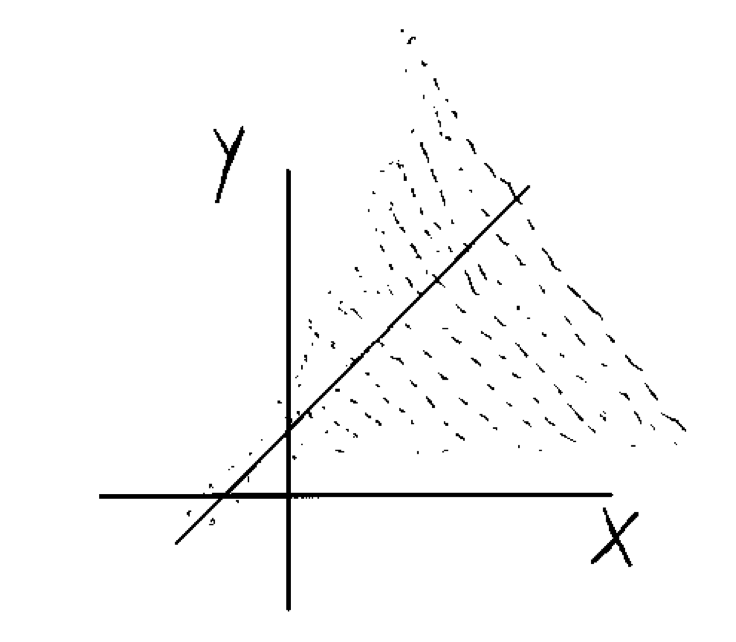

## Above: This is a very heteroskedastic plot. 
- The distance between each value and the line is the residual 
Residual: almost interchangeable with error 
- If we have a small standard error (averaging all of the errors) it wouldn't show the show graph's real error.
- The left side is deceptive because it's really predictive. The errors are ///
really small. But as x grows, the values are more spread out and the line is less predictive. This is what we need to account for

### IMPORTANT: For the standard error to be valid, it has to be consistent across all x values 

In [4]:
%set graph_height = 8

graph size was (11, 4in), is now (11, 8).


In [5]:
%set graph_width = 11

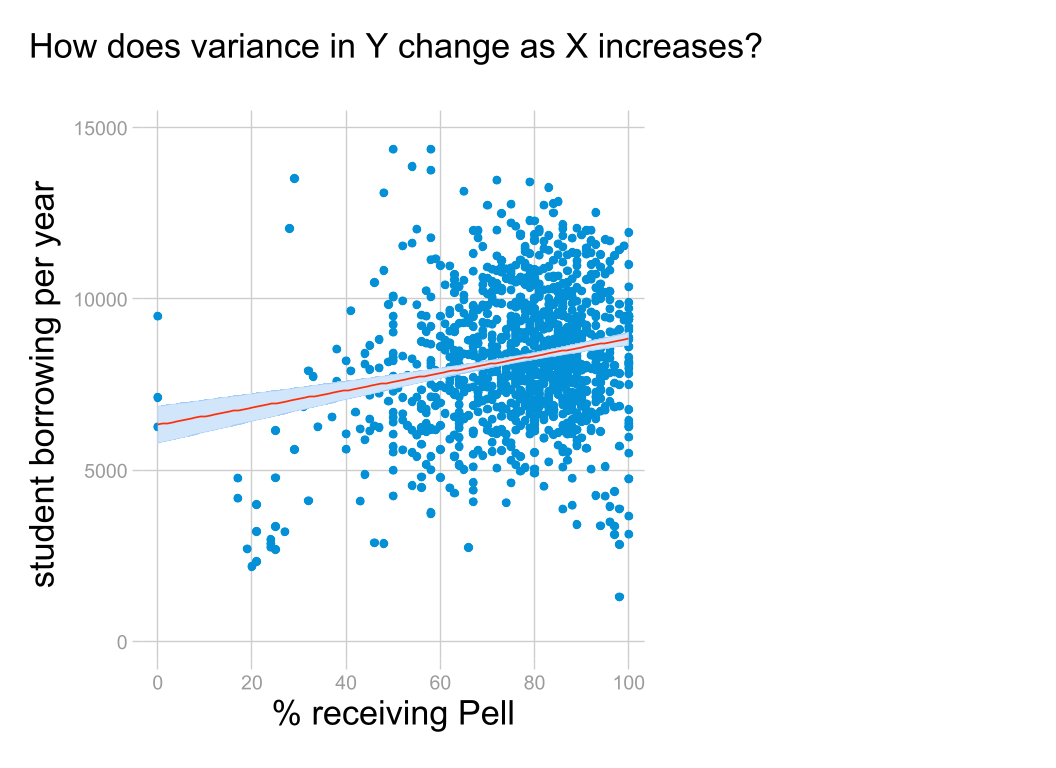

In [6]:
quietly cd ../week9
quietly use forprofits20200317, clear
tw (scatter loan_amount_borrower_c_w fed_grant_pct_w) ///
(lfitci loan_amount_borrower_c_w fed_grant_pct_w), ///
ytitle(student borrowing per year, size(large)) ///
xtitle(,size(large)) legend(off) scheme(538w) ///
title("How does variance in Y change as X increases?" " ", span size(large)) ///
aspect(1, place(west))

### Use regression tests to be sure

Breusch–Pagan heteroscedasticity "hettest" is standard:

A large chi2 statistic and low probability for chi2 indicates that heteroskedasticity is a problem.


      Source |       SS           df       MS      Number of obs   =     1,198
-------------+----------------------------------   F(1, 1196)      =     48.50
       Model |   177217722         1   177217722   Prob > F        =    0.0000
    Residual |  4.3699e+09     1,196   3653751.3   R-squared       =    0.0390
-------------+----------------------------------   Adj R-squared   =    0.0382
       Total |  4.5471e+09     1,197  3798750.44   Root MSE        =    1911.5

------------------------------------------------------------------------------
loan_amoun~w | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
fed_grant_~w |   25.09973   3.604002     6.96   0.000     18.02886     32.1706
       _cons |   6328.394   281.8288    22.45   0.000      5775.46    6881.328
------------------------------------------------------------------------------

Breusch–Pagan/Cook–Weisberg test for heteroskedas

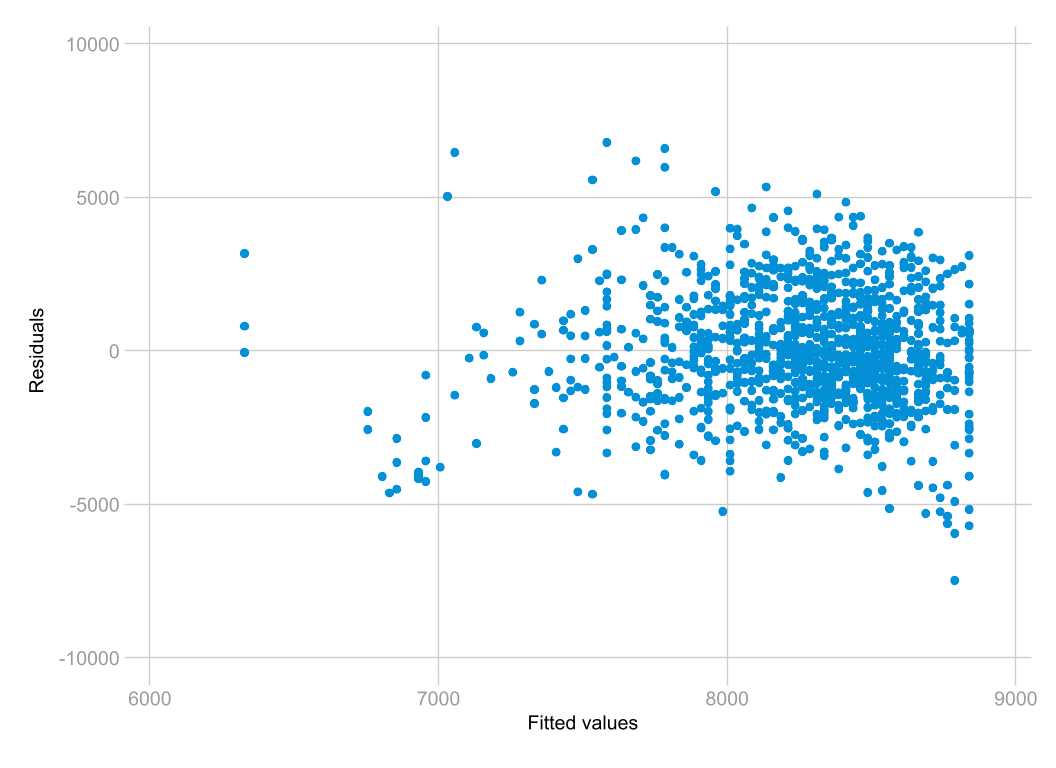

In [8]:
regress loan_amount_borrower_c_w fed_grant_pct_w
estat hettest
rvfplot, scheme(538w)

## 2. Nonlinear estimation solutions

We learned these in week 7:

* change in increments (sequential dummy variables)

* change direction or strength abruptly (spline)

* change direction gradually (quadratic)

* accelerate/decelerate -- i.e. curve (logarithmic)

Does this help in the case of average loan debt?

In [5]:
gen loan_amount_borrower_c_wln=log(loan_amount_borrower_c_w)

In [6]:
quietly regress loan_amount_borrower_c_wln fed_grant_pct_w
estat hettest


Breusch–Pagan/Cook–Weisberg test for heteroskedasticity 
Assumption: Normal error terms
Variable: Fitted values of loan_amount_borrower_c_wln

H0: Constant variance

    chi2(1) =  44.43
Prob > chi2 = 0.0000


## 3. Bootrapping is another solution

Bootstrapping approximates resampling by taking the observed sample as a proxy for the population and repeatedly sampling, with replacement, observations from the observed sample (Treimann 239).
- Replacement: Takes a sample of the sample, then does it again without taking those observations out. So every time it's taking from the full sample 


By taking repeated samples and reestimating standard errors, we can better estimate the standard deviation of potential regression coefficients for repeated samples of the population (aka the standard error of the coefficient).

This works the same ways as the standard error of the mean:

In [9]:
ssc install stripplot

checking stripplot consistency and verifying not already installed...
installing into C:\Users\User\ado\plus\...
installation complete.


In [10]:
%set graph_height = 1

graph size was (11, 8), is now (11, 1).


In [11]:
%set graph_width = 11

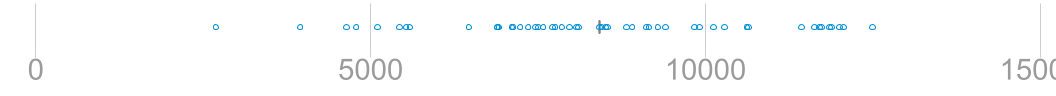

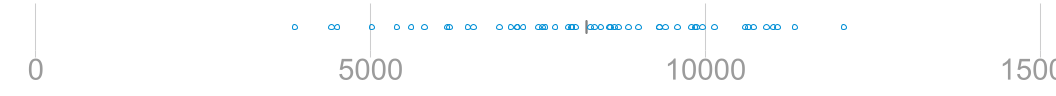

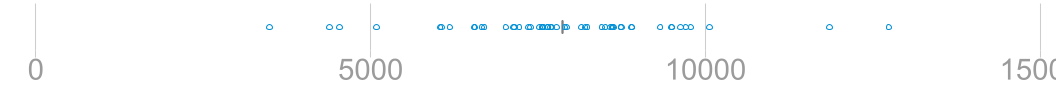

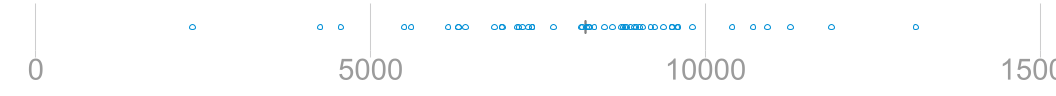

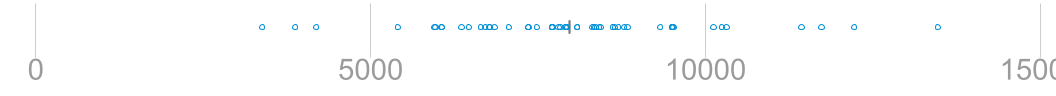

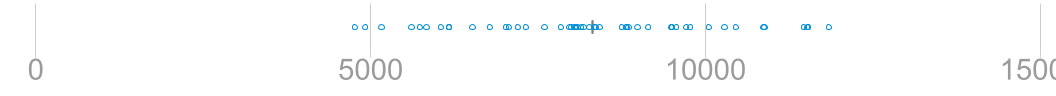

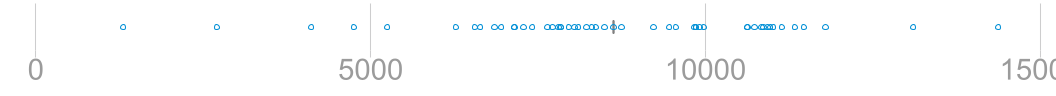

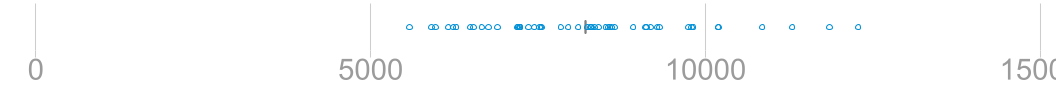

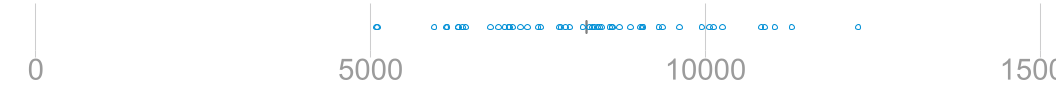

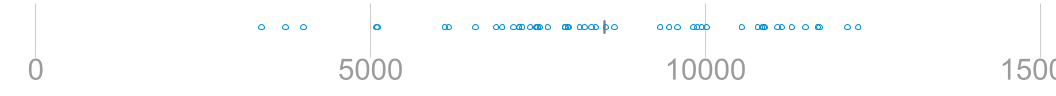

In [16]:
quietly use forprofits20200317, clear
quietly keep if loan_amount_borrower_c_w!=.
quietly gen debtmeans=.
quietly gen n=_n
forvalues i=1/10 {
    quietly gen random=runiform()
    quietly sort random
  stripplot loan_amount_borrower_c_w if _n<=50, scheme(538w) refline  ///
    ysize(1) xsize(10) scale(5) xtitle("") xlabel(0(5000)15000, labsize(vlarge)) name(g`i', replace)

    drop random
    }

*Above for ten iterations, sort them based on a 
// new variable that's basically a random number generator. 
// Then plot blue dots for their values of y. Then draw a little line for the mean 




In [10]:
%set graph_height = 4

graph size was (11, 1), is now (11, 4).


(bin=90, start=0, width=100)


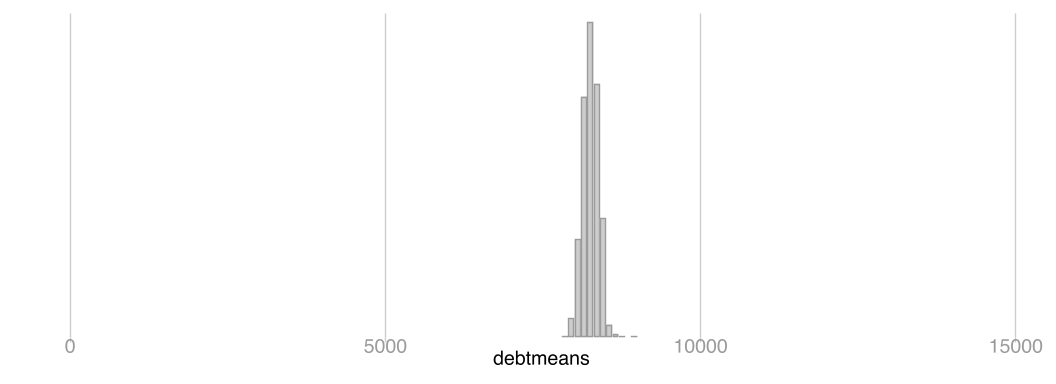

In [14]:
quietly {
 forvalues i=11/1000 {
    quietly gen random=runiform()
    quietly sort random    
    quietly sum loan_amount_borrower_c_w if _n<=200
    quietly replace debtmeans=r(mean) if n==`i'
    quietly drop random
}
}
histogram debtmeans, scheme(538w) start(0) width(100) xlabel(0(5000)15000) ytitle(" ") ylabel(none)

(bin=29, start=7893.5, width=34.708277)


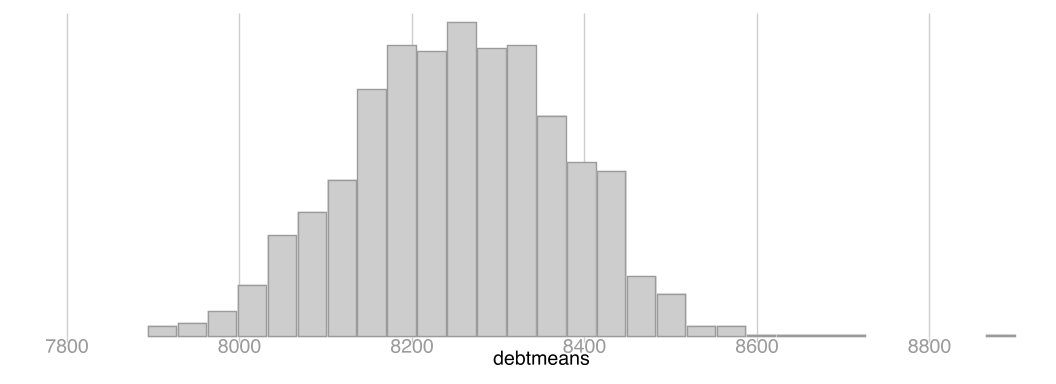

In [15]:
histogram debtmeans, scheme(538w) ytitle(" ") ylabel(none)

### Lets compare OLS standard errors with bootstrapped standard errors:

In [17]:
est clear
quietly reg loan_amount_borrower_c_w fed_grant_pct_w
quietly eststo
quietly bootstrap _b[fed_grant_pct_w], rep(1000) nodots : ///
    reg loan_amount_borrower_c_w fed_grant_pct_w
quietly eststo

In [18]:
esttab, ///
mlabels("OLS" "Bootstrap") ///
collabels(none)  ///
cells(b(star fmt(2)) se(fmt(2) par)) ///
starlevels(^ .1 * .05 ** .01 *** .001) 


--------------------------------------------
                      (1)             (2)   
                      OLS       Bootstrap   
--------------------------------------------
fed_grant_~w        25.10***                
                   (3.60)                   
_bs_1                               25.10***
                                   (4.67)   
_cons             6328.39***                
                 (281.83)                   
--------------------------------------------
N                    1198            1198   
--------------------------------------------


### 4. Robust standard errors solution

* Robust standard errors: error estimates that apply more weight to larger deviations and less weight to smaller deviations (Treiman 237)

<img src="robusterrorfunctions.png" width="800" align="left">

* This is computationally much more efficient/faster than bootstrapping

* The code is also simpler

In [19]:
quietly reg loan_amount_borrower_c_w fed_grant_pct_w, robust
quietly eststo

In [20]:
esttab, ///
mlabels("OLS" "Bootstrap" "Robust") ///
collabels(none) drop(_cons) ///
cells(b(star fmt(2)) se(fmt(2) par)) ///
starlevels(^ .1 * .05 ** .01 *** .001) 


------------------------------------------------------------
                      (1)             (2)             (3)   
                      OLS       Bootstrap          Robust   
------------------------------------------------------------
fed_grant_~w        25.10***                        25.10***
                   (3.60)                          (4.61)   
_bs_1                               25.10***                
                                   (4.67)                   
------------------------------------------------------------
N                    1198            1198            1198   
------------------------------------------------------------


## 5. Cluster Robust standard errors

* Cluster robust standard errors are necessary when your data measures indivdual units within groups that can affect measurement patterns.

* An example of this would be a study student learning (DV) of 1,000 students who are enrolled in 100 different schools. Ideally, you would have a variable that records which school each student is in.

* For the for-profit study, I measure student debt (DV) by school based on the Pell enrollment (IV) of each school. But multiple for-profit colleges are owned by parent companies some times. So I need to cluster standard errors by the **"systemid"** indicating the company owning a school:

In [23]:
qui reg loan_amount_borrower_c_w fed_grant_pct_w,  cluster(systemid)
quietly eststo

In [24]:
esttab, ///
mlabels("OLS" "Bootstrap" "Robust" "Cluster") ///
collabels(none) drop(_cons) ///
cells(b(star fmt(2)) se(fmt(2) par)) ///
starlevels(^ .1 * .05 ** .01 *** .001)  legend


----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                      OLS       Bootstrap          Robust         Cluster   
----------------------------------------------------------------------------
fed_grant_~w        25.10***                        25.10***        25.10^  
                   (3.60)                          (4.61)         (12.77)   
_bs_1                               25.10***                                
                                   (4.66)                                   
----------------------------------------------------------------------------
N                    1198            1198            1198            1198   
----------------------------------------------------------------------------
^ p<.1, * p<.05, ** p<.01, *** p<.001


### Being clustered in a company may reduce variance for colleges in the DV

### Then if we don't have a lot of companies, the clustering is making variance lower than what we could predict for other companies or future for-profit colleges

*Might introduce patterns to your error that you don't want*

In [29]:
list unitid systemid inst if _n<11
list unitid systemid inst if regexm(inst_name_new, "DEVRY")==1


      +-----------------------------------------------------------------+
      | unitid   systemid                                 inst_name_new |
      |-----------------------------------------------------------------|
   1. | 437060     245342               VATTEROTT COLLEGE-OKLAHOMA CITY |
   2. | 134680     179201                   SANFORD-BROWN COLLEGE-TAMPA |
   3. | 441016     115515              NATIONAL INSTITUTE OF TECHNOLOGY |
   4. | 184816     212212      GORDON PHILLIPS SCHOOL OF BEAUTY CULTURE |
   5. | 450076     373784                             MEDIX SCHOOL-WEST |
      |-----------------------------------------------------------------|
   6. | 261719     169734               TAYLORTOWN SCHOOL OF BEAUTY INC |
   7. | 482529     104531                    DEVRY UNIVERSITY-MINNESOTA |
   8. | 482398     101116                 THE ART INSTITUTE OF ST LOUIS |
   9. | 443234     443234   AMERICAN INSTITUTE-SCHOOL OF HEALTH CAREERS |
  10. | 479600     105163            